### Importing the dataset

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Folder where all images are located
mydir = 'data'

#### * Coding System

In [21]:
labels = np.array([])

i=0
for file in os.listdir(mydir):
    if file.endswith(".JPG"): # Will only read .jpg files (you can change this to other formats)
        filename = mydir+'/'+file
        # Loads image, converts to grayscale and resizes it to a 300x300 image
        y = np.array(Image.open(filename).convert('RGB').convert('L').resize((600,600)))
        
        # Resizes 300x300 image to 90,000x1 array
        col_y = y.ravel()[:,np.newaxis]
        
        # Saves
        if i==0:
            data = col_y
        else:
            data = np.hstack((data, col_y))
        
        # Creates labels from filename
        if i < 40: # Females (0)
            labels = np.hstack((labels, int(0))) # this assumes the file extension has 3 letters (such as jpg)
        else: # Males (1)
            labels = np.hstack((labels, int(1))) # this assumes the file extension has 3 letters (such as jpg)
        i+=1

print('-------------------------------------------------------')
print('----------------------DONE-----------------------------')
print('-------------------------------------------------------')
print('There are ', data.shape[1],' images')
print('There are ', labels.shape[0],' labels')

# Saves the files to your current directory
np.save('data', data)
np.save('labels', labels)

-------------------------------------------------------
----------------------DONE-----------------------------
-------------------------------------------------------
There are  80  images
There are  80  labels


#### Loading the data and splitting up the dataset into training and test

In [22]:
data = np.load('data.npy')
labels = np.load('labels.npy')

print(data.shape, labels.shape)

(360000, 80) (80,)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [24]:
data.shape

(360000, 80)

### Pre-processing

In [25]:
# Importing openCV to preprocess
import cv2

In [26]:
# Function to normalize data by dividing each pixel value by 255
def normalize(data):
    return (data.astype(float)/255)

In [27]:
data_normalized = normalize(data)
print(data_normalized.shape)

(360000, 80)


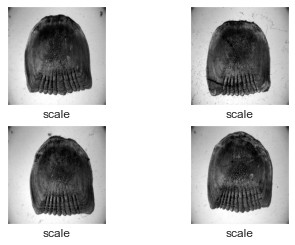

In [28]:
fig, ax = plt.subplots(2, 2)
for i, axi in enumerate(ax.flat):
    axi.imshow(data[:,i].reshape(600,600), cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel="scale")

### Testing for the best model

In [29]:
# Preparing SVC and PCA
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [30]:
# Breaking the data into a training a test set
Xtrain, Xtest, ytrain, ytest = train_test_split(data_normalized.T, labels,
                                                random_state=42)

In [12]:
i=8
best_accuracy = 0
best_model = 0
best_num_components = 0
best_grid = 0
for nums in range(5):
    # Setting up PCA and SVM
    pca = RandomizedPCA(n_components=i, whiten=True, svd_solver='full', random_state=42)
    svc = SVC(kernel='rbf', class_weight='balanced')
    model = make_pipeline(pca, svc)
    # Determining the best coefficents
    param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 3, 5, 10, 50],
              'svc__gamma': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
    grid = GridSearchCV(model, param_grid)
    # Testing the Model
    grid.fit(Xtrain, ytrain)
    print(grid.best_params_)
    model = grid.best_estimator_
    yfit = model.predict(Xtest)
    # Checking the accuracy
    accuracy = accuracy_score(yfit, ytest)
    if (accuracy > best_accuracy):
        best_accuracy = accuracy
        best_model = model
        best_grid = grid
        best_num_components = i
    i+=1
    
print("The best accuracy was",best_accuracy)
print(grid.best_params_)

{'svc__C': 10, 'svc__gamma': 0.01}
{'svc__C': 1, 'svc__gamma': 0.01}
{'svc__C': 0.75, 'svc__gamma': 0.01}
{'svc__C': 0.01, 'svc__gamma': 5e-05}
{'svc__C': 0.01, 'svc__gamma': 0.01}
The best accuracy was 0.9
{'svc__C': 0.01, 'svc__gamma': 0.01}


In [31]:
# Running the best model afterwards: 
pca = RandomizedPCA(n_components=8, whiten=True, svd_solver='full', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
# Determining the best coefficents
# Determining the best coefficents
param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 3, 5, 10, 50],
              'svc__gamma': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
grid = GridSearchCV(model, param_grid)
# Testing the Model
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
model = grid.best_estimator_
yfit = model.predict(Xtest)

{'svc__C': 10, 'svc__gamma': 0.01}


In [13]:
# Testing the Model
yfit = best_model.predict(Xtest)

In [32]:
yfit,ytest

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1.]))

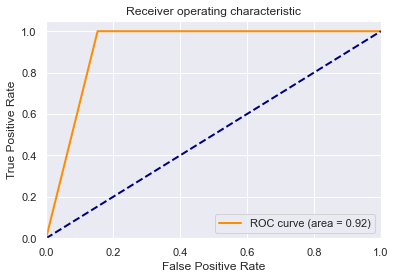

In [33]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(yfit, ytest, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
yfit = best_model.predict(Xtest)
print(classification_report(y_true=ytest, y_pred=yfit)), best_num_components

NameError: name 'best_model' is not defined

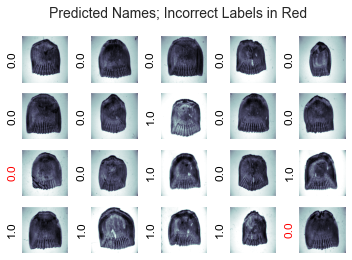

In [35]:
fig, ax = plt.subplots(4, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i,:].reshape(600,600), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit[i],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

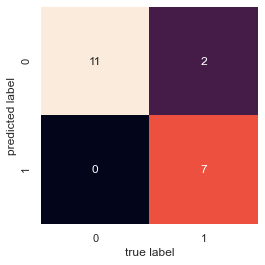

In [34]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');